In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import math
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# pip install imblearn


In [3]:
# Parameter ranges
param_ranges = {
    'mH2': (130, 1000),
    'mA': (60, 1000),
    'mHpm': (80, 1000),
    'tan_beta': (0.5, 100),
}

In [4]:
# Function to generate a sample

def generate_sample():
    sample = {param: np.random.uniform(low, high)
              for param, (low, high) in param_ranges.items()}
    sample['mH1'] = 125
    sample['tan_alpha'] = sample['tan_beta']
    tan_beta = sample['tan_beta']
    tan_alpha = sample['tan_alpha']

    s_beta = tan_beta / np.sqrt(1 + tan_beta**2)
    c_beta = 1 / np.sqrt(1 + tan_beta**2)
    s_alpha = tan_alpha / np.sqrt(1 + tan_alpha**2)
    c_alpha = 1 / np.sqrt(1 + tan_alpha**2)

    sample['v'] = 246

    sample['lambda1'] = ((c_alpha**2 * sample['mH1']**2) +
                         (s_alpha**2 * sample['mH2']**2)) / (sample['v']**2 * c_beta**2)

    sample['lambda2'] = ((c_alpha**2 * sample['mH2']**2) +
                         (s_alpha**2 * sample['mH1']**2)) / (sample['v']**2 * s_beta**2)

    sample['lambda4'] = (
        sample['mA']**2 - (2 * sample['mHpm']**2)) / sample['v']**2

    sample['lambda5'] = -(sample['mA']**2 / sample['v']**2)

    sample['lambda3'] = (((sample['mH1']**2 - sample['mH2']**2) * s_alpha * c_alpha) - (
        (sample['lambda4'] + sample['lambda5']) * sample['v']**2 * c_beta * s_beta)) / (sample['v']**2 * c_beta * s_beta)

    # Checking theoretical constraints

    #   Stability
    Stability_check = sample['lambda1'] > 0 and sample['lambda2'] > 0 and \
        (sample['lambda3'] + np.sqrt(sample['lambda1']
                                     * sample['lambda2']) > 0) and \
        (sample['lambda3'] + sample['lambda4'] - abs(sample['lambda5'])
         + np.sqrt(sample['lambda1'] * sample['lambda2']) > 0)

    # Perturbativity
    Perturbativity_check = all(
        abs(sample[f'lambda{i}']) <= 4 * np.pi for i in range(1, 6))

    # unitary check
    lambda1 = sample['lambda1']
    lambda2 = sample['lambda2']
    lambda3 = sample['lambda3']
    lambda4 = sample['lambda4']
    lambda5 = sample['lambda5']

    u1_plus = 0.5 * (lambda1 + lambda2 +
                     np.sqrt((lambda1 - lambda2)**2 + 4 * abs(lambda5)**2))
    u1_minus = 0.5 * (lambda1 + lambda2 -
                      np.sqrt((lambda1 - lambda2)**2 + 4 * abs(lambda5)**2))

    u2_plus = 0.5 * (lambda1 + lambda2 +
                     np.sqrt((lambda1 - lambda2)**2 + 4 * lambda4**2))
    u2_minus = 0.5 * (lambda1 + lambda2 -
                      np.sqrt((lambda1 - lambda2)**2 + 4 * lambda4**2))

    u3_plus = 0.5 * (3*(lambda1 + lambda2) + np.sqrt((9 *
                     (lambda1 - lambda2)**2) + 4 * ((2 * lambda3) + lambda4)**2))
    u3_minus = 0.5 * (3*(lambda1 + lambda2) - np.sqrt((9 *
                      (lambda1 - lambda2)**2) + 4 * ((2 * lambda3) + lambda4)**2))

    u4_plus = lambda3 + (2 * lambda4) + 3 * (abs(lambda5))
    u4_minus = lambda3 + (2 * lambda4) - 3 * (abs(lambda5))

    u5_plus = lambda3 + abs(lambda5)
    u5_minus = lambda3 - abs(lambda5)

    u6_plus = lambda3 + lambda4
    u6_minus = lambda3 - lambda4

    # Check if all unitary constraints are satisfied
    unitary_check = all(abs(u) <= 8 * np.pi for u in [
        u1_plus, u1_minus,
        u2_plus, u2_minus,
        u3_plus, u3_minus,
        u4_plus, u4_minus,
        u5_plus, u5_minus,
        u6_plus, u6_minus
    ])

    sample['label'] = int(
        Stability_check and Perturbativity_check and unitary_check)

    return sample

In [5]:
# data = [generate_sample() for _ in range(500000)]
# df_sample = pd.DataFrame(data)

# df_sample.to_csv('2_hdm_nn_dataset_25.csv',index=False)
# # df_sample.tail()

In [6]:
# # merging multiple datasets  csv files
# import pandas as pd
# no_of_datasets = 25
# # List to hold all dataframes
# dfs = []

# # Loop to read each CSV file and append to the list
# for i in range(1, no_of_datasets+1):
#     file_name = f'2_hdm_nn_dataset_{i}.csv'
#     df = pd.read_csv(file_name)
#     dfs.append(df)

# # Concatenate all dataframes in the list
# merged_df = pd.concat(dfs, ignore_index=True)
# merged_df = pd.DataFrame(merged_df)



In [7]:
# merged_df.to_csv('merged_df.csv',index=False)

In [8]:
# df.to_csv('2_hdm_nn_dataset.csv',index=False)

In [9]:
df_merged = pd.read_csv('merged_df.csv')
df_merged

,mH2,mA,mHpm,tan_beta,mH1,tan_alpha,v,lambda1,lambda2,lambda4,lambda5,lambda3,label
0,889.904028,746.410814,745.430293,50.221607,125,50.221607,246,33006.596403,0.263385,-9.157967,-9.206311,5.536196,0
1,952.963450,88.879336,809.208842,33.984694,125,33.984694,246,17332.271220,0.271189,-21.510648,-0.130536,6.892781,0
2,511.713098,250.403702,550.957654,2.332967,125,2.332967,246,23.808688,1.053194,-8.996078,-1.036123,5.963437,0
3,405.838452,957.239181,261.601836,99.264004,125,99.264004,246,26817.848183,0.258472,12.879830,-15.141563,-0.201745,0
4,793.430013,502.967547,314.839949,24.138349,125,24.138349,246,6061.507529,0.276050,0.904355,-4.180322,-6.868560,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
12499995,524.842784,761.122253,286.532699,15.622265,125,15.622265,246,1111.161432,0.276847,6.859427,-9.572792,-1.580292,0
12499996,551.158190,118.546868,174.506200,87.173547,125,87.173547,246,38146.499766,0.258857,-0.774200,-0.232226,-3.755131,0
12499997,970.913931,662.228278,655.386011,88.573381,125,88.573381,246,122207.711175,0.260182,-6.948829,-7.246783,-1.123458,0
12499998,935.824359,622.556337,400.025472,22.567754,125,22.567754,246,7370.727654,0.286611,1.115996,-6.404528,-8.924937,0


In [10]:
count1 = df_merged[df_merged.label == 1].count()['label']
count1

37693

In [11]:
count0 = df_merged[df_merged.label == 0].count()['label']
count0

12462307

Balances the merged dataset 

In [12]:
# import pandas as pd

# df = pd.read_csv('merged_df.csv')

# # Separate the rows with label 1
# df_1 = df[df['label'] == 1]

# # Separate the rows with label 0
# df_0 = df[df['label'] == 0]

# desired_ratio = 0.40
# n_1 = len(df_1)
# n_0_to_keep = int(desired_ratio * n_1)

# # Randomly sample the desired number of rows from df_0
# df_0_sampled = df_0.sample(n=min(n_0_to_keep, len(df_0)), random_state=42)

# # Concatenate the sampled rows with the df_1
# balanced_df = pd.concat([df_1, df_0_sampled], ignore_index=True)

# # Shuffle the new balanced dataframe
# balanced_df = balanced_df.sample(frac=1, random_state=42).reset_index(drop=True)

# balanced_df = pd.DataFrame(balanced_df)

In [13]:
import pandas as pd

def balance_dataset(df, label_column, desired_ratio=0.40, random_state=42):
    
    # Separate the rows with label 1
    df_1 = df[df[label_column] == 1]

    # Separate the rows with label 0
    df_0 = df[df[label_column] == 0]

    # Calculate the number of rows to keep from df_0
    n_1 = len(df_1)
    n_0_to_keep = int(desired_ratio * n_1)

    # Randomly sample the desired number of rows from df_0
    df_0_sampled = df_0.sample(n=min(n_0_to_keep, len(df_0)), random_state=random_state)

    # Concatenate the sampled rows with the df_1
    balanced_df = pd.concat([df_1, df_0_sampled], ignore_index=True)

    # Shuffle the new balanced dataframe
    balanced_df = balanced_df.sample(frac=1, random_state=random_state).reset_index(drop=True)

    return balanced_df



In [14]:
# balanced_df.to_csv('balanced_df_9.csv')   

In [15]:
# df = pd.read_csv('balanced_df.csv')
df = pd.read_csv('balanced_df_9.csv')

In [16]:
df.shape

(52770, 14)

In [17]:
count1 = df[df.label == 1].count()['label']
count1

37693

In [18]:
count0 = df[df.label == 0].count()['label']
count0

15077

In [19]:
df.head()

,Unnamed: 0,mH2,mA,mHpm,tan_beta,mH1,tan_alpha,v,lambda1,lambda2,lambda4,lambda5,lambda3,label
0,0,351.735612,257.356571,539.806013,90.517132,125,90.517132,246,16750.614071,0.258446,-8.535737,-1.094461,7.844010,0
1,1,236.590661,613.905150,469.295875,1.943100,125,1.943100,246,3.750528,0.503178,-1.050924,-6.227767,6.611922,1
2,2,171.255948,267.631837,219.263356,3.122078,125,3.122078,246,4.982182,0.307916,-0.405282,-1.183601,1.362437,1
3,3,376.282336,95.370321,270.023633,40.707262,125,40.707262,246,3877.306757,0.259608,-2.259403,-0.150299,0.328213,0
4,4,261.332987,401.058943,298.111778,48.076994,125,48.076994,246,2608.770325,0.258684,-0.279149,-2.657946,2.066748,0


In [20]:
df = df.drop(columns=['Unnamed: 0'])


In [21]:
df.head()

,mH2,mA,mHpm,tan_beta,mH1,tan_alpha,v,lambda1,lambda2,lambda4,lambda5,lambda3,label
0,351.735612,257.356571,539.806013,90.517132,125,90.517132,246,16750.614071,0.258446,-8.535737,-1.094461,7.844010,0
1,236.590661,613.905150,469.295875,1.943100,125,1.943100,246,3.750528,0.503178,-1.050924,-6.227767,6.611922,1
2,171.255948,267.631837,219.263356,3.122078,125,3.122078,246,4.982182,0.307916,-0.405282,-1.183601,1.362437,1
3,376.282336,95.370321,270.023633,40.707262,125,40.707262,246,3877.306757,0.259608,-2.259403,-0.150299,0.328213,0
4,261.332987,401.058943,298.111778,48.076994,125,48.076994,246,2608.770325,0.258684,-0.279149,-2.657946,2.066748,0


In [22]:
df.shape

(52770, 13)

In [23]:
df.columns

Index(['mH2', 'mA', 'mHpm', 'tan_beta', 'mH1', 'tan_alpha', 'v', 'lambda1',
       'lambda2', 'lambda4', 'lambda5', 'lambda3', 'label'],
      dtype='object')

In [24]:
import matplotlib.pyplot as plt

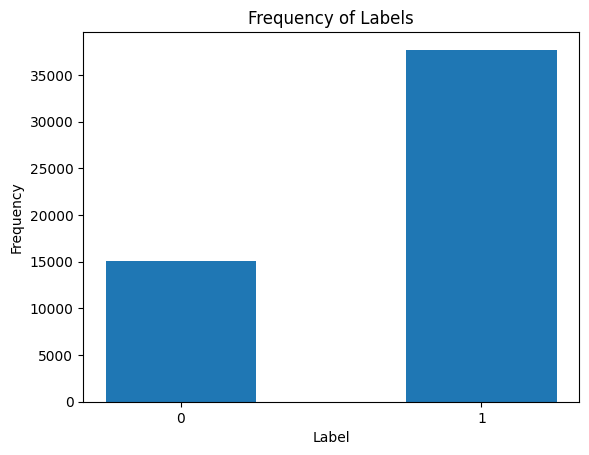

In [25]:
label_counts = df['label'].value_counts().reindex([0, 1], fill_value=0)

# Create a bar plot
plt.bar(label_counts.index, label_counts.values, width=0.5)
plt.xlabel('Label')
plt.ylabel('Frequency')
plt.title('Frequency of Labels')
plt.xticks([0, 1])  # Ensure x-ticks are only 0 and 1
plt.show()

In [26]:
df.head()

,mH2,mA,mHpm,tan_beta,mH1,tan_alpha,v,lambda1,lambda2,lambda4,lambda5,lambda3,label
0,351.735612,257.356571,539.806013,90.517132,125,90.517132,246,16750.614071,0.258446,-8.535737,-1.094461,7.844010,0
1,236.590661,613.905150,469.295875,1.943100,125,1.943100,246,3.750528,0.503178,-1.050924,-6.227767,6.611922,1
2,171.255948,267.631837,219.263356,3.122078,125,3.122078,246,4.982182,0.307916,-0.405282,-1.183601,1.362437,1
3,376.282336,95.370321,270.023633,40.707262,125,40.707262,246,3877.306757,0.259608,-2.259403,-0.150299,0.328213,0
4,261.332987,401.058943,298.111778,48.076994,125,48.076994,246,2608.770325,0.258684,-0.279149,-2.657946,2.066748,0


In [27]:
features = ['mH2', 'mA', 'mHpm', 'tan_beta', 'tan_alpha', 'mH1', 'v']
X = df[features].values
y = df['label'].values

In [28]:
pd.DataFrame(X)

,0,1,2,3,4,5,6
0,351.735612,257.356571,539.806013,90.517132,90.517132,125.0,246.0
1,236.590661,613.905150,469.295875,1.943100,1.943100,125.0,246.0
2,171.255948,267.631837,219.263356,3.122078,3.122078,125.0,246.0
3,376.282336,95.370321,270.023633,40.707262,40.707262,125.0,246.0
4,261.332987,401.058943,298.111778,48.076994,48.076994,125.0,246.0
...,...,...,...,...,...,...,...
52765,235.106948,280.932094,221.425473,1.881115,1.881115,125.0,246.0
52766,371.951617,99.230841,717.870592,44.444702,44.444702,125.0,246.0
52767,286.173967,585.355731,153.629339,3.308887,3.308887,125.0,246.0
52768,132.110341,376.975194,280.542189,3.237250,3.237250,125.0,246.0


In [29]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

In [30]:
pd.DataFrame(X_train)

,0,1,2,3,4,5,6
0,139.775545,202.168241,203.351245,1.906236,1.906236,125.0,246.0
1,201.967739,518.047926,333.767531,2.837304,2.837304,125.0,246.0
2,904.406167,80.163295,785.285730,25.226575,25.226575,125.0,246.0
3,214.228538,196.412444,329.017521,1.281031,1.281031,125.0,246.0
4,210.728364,260.546583,438.231005,1.047121,1.047121,125.0,246.0
...,...,...,...,...,...,...,...
42211,332.764785,546.126360,198.410341,0.883268,0.883268,125.0,246.0
42212,212.266901,132.001094,457.737688,1.645531,1.645531,125.0,246.0
42213,239.506179,116.598099,297.402137,2.279247,2.279247,125.0,246.0
42214,137.831955,535.350827,468.589886,0.763251,0.763251,125.0,246.0


In [31]:
# Normalize the features
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)  # Use transform, not fit_transform


In [32]:
# pip install tensorflow

Input Layer (features) -> Hidden Layer 1 (64 neurons, ReLU) -> Hidden Layer 2 (32 neurons, ReLU) -> Output Layer (1 neuron, Sigmoid)


In [33]:
#  pip install xgboost

In [34]:
from sklearn.metrics import accuracy_score, classification_report
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
import xgboost as xgb
from tensorflow.keras.regularizers import l2
from keras.regularizers import l1_l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau
from sklearn.utils import class_weight
from sklearn.model_selection import GridSearchCV



In [ ]:
#neural network 
model = Sequential()
model.add(Dense(64, input_dim=len(features), activation='relu', kernel_regularizer=l1_l2(l1=0.001, l2=0.001)))
model.add(Dropout(0.3))  
model.add(Dense(32, activation='relu', kernel_regularizer=l1_l2(l1=0.001, l2=0.001)))
model.add(Dropout(0.3))  
model.add(Dense(1, activation='sigmoid'))


# Compile the model
optimizer = Adam(learning_rate=0.0001,clipnorm=1)
model.compile(loss='binary_crossentropy',
              optimizer=optimizer, metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

class_weights = class_weight.compute_class_weight('balanced',classes=np.unique(y_train),y=y_train)
class_weights_dict = dict(enumerate(class_weights))



# Train the model
history = model.fit(X_train, y_train, epochs=100,
                    batch_size=64, validation_split=0.2,callbacks=[early_stopping], 
                    class_weight=class_weights_dict)


# Extract features using the trained neural network
feature_extractor = Sequential(model.layers[:-1])  # Remove the last layer
X_train_features = feature_extractor.predict(X_train)
X_test_features = feature_extractor.predict(X_test)

# Hyperparameter tuning for XGBoost
param_grid = {
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'n_estimators': [50, 100, 200]
}

# Train XGBoost on the features extracted by the neural network
XGB_model = xgb.XGBClassifier(learning_rate=0.1, max_depth=5, n_estimators=10)
grid_search = GridSearchCV(estimator=XGB_model, param_grid=param_grid, scoring='precision', cv=5)
grid_search.fit(X_train_features, y_train)
best_params = grid_search.best_params_

# Train XGBoost with best hyperparameters
XGB_model = xgb.XGBClassifier(**best_params)
XGB_model.fit(X_train_features, y_train)

# XGB_model = xgb.XGBClassifier(learning_rate=0.1, max_depth=5, n_estimators=10)
# XGB_model.fit(X_train_features, y_train)


# Evaluate the XGBoost model
result_train = XGB_model.score(X_train_features, y_train)
print("Training Accuracy:", result_train)
result_test = XGB_model.score(X_test_features, y_test)
print("Testing Accuracy:", result_test)


c:\Users\KIIT\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
528/528 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.6719 - loss: 1.0222 - val_accuracy: 0.9757 - val_loss: 0.7916
Epoch 2/100
528/528 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9451 - loss: 0.7005 - val_accuracy: 0.9764 - val_loss: 0.5171
Epoch 3/100
528/528 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9686 - loss: 0.4839 - val_accuracy: 0.9802 - val_loss: 0.3749
Epoch 4/100
528/528 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9752 - loss: 0.3748 - val_accuracy: 0.9827 - val_loss: 0.3030
Epoch 5/100
528/528 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9776 - loss: 0.3149 - val_accuracy: 0.9832 - val_loss: 0.2610
Epoch 6/100
528/528 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9795 - loss: 0.2803 - val_accuracy: 0.9853 - val_loss: 0.2438
Epoch 7/100
528/528 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9805 - loss: 0.2587 - val_accuracy: 0.9860 - val_loss: 0.2306
Epoch 8/100
528/528 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9805 - loss: 0.2481 - val_accu

In [36]:

# Predict and tune threshold for precision
y_pred_proba = XGB_model.predict_proba(X_test_features)[:, 1]
threshold = 0.5  # Adjust this value
y_predict = (y_pred_proba > threshold).astype(int)
y_predict

array([1, 0, 1, ..., 1, 1, 0])

In [37]:
# precision = precision_score(y_test,y_pred_xgb)
# print("Precision : ",precision)

In [38]:
result_test = XGB_model.score(X_test_features, y_test)
print("Test Accuracy : {}".format(result_test))

Test Accuracy : 0.9961152169793444


In [39]:
# predict the score of the trained model using the training dataset
result_train = XGB_model.score(X_train_features, y_train)
print("Train Accuracy : {}".format(result_train))

Train Accuracy : 0.9985787379192723


In [40]:
from sklearn import metrics
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score

In [41]:
print(f'Number of ones in xgb : {np.sum(y_predict == 1)}')

Number of ones in xgb : 7597


In [43]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score

# Confusion Matrix
cm = confusion_matrix(y_test, y_predict)
print("Confusion Matrix:")
print(cm)

# Precision
precision = precision_score(y_test, y_predict)
print("Precision:", precision)

# Recall
recall = recall_score(y_test, y_predict)
print("Recall:", recall)

# F1 Score
f1 = f1_score(y_test, y_predict)
print("F1 Score:", f1)

Confusion Matrix:
[[2953   37]
 [   4 7560]]
Precision: 0.9951296564433328
Recall: 0.9994711792702274
F1 Score: 0.997295692896247


330/330 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9911 - loss: 0.0851
Test Accuracy: 0.9920409321784973


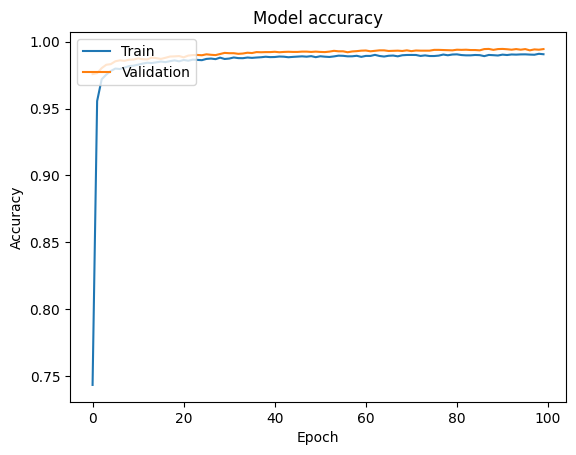

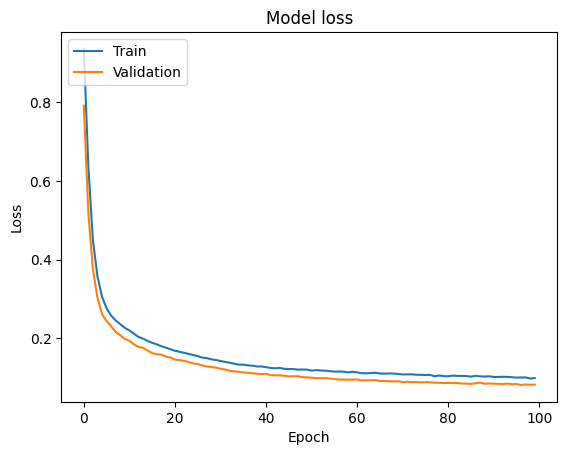

In [44]:
# Evaluate the model
import matplotlib.pyplot as plt
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy}")

# Plot training & validation accuracy values

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [45]:
data = [generate_sample() for _ in range(500000)]
df_sample = pd.DataFrame(data)

In [46]:
df_sample.head()

,mH2,mA,mHpm,tan_beta,mH1,tan_alpha,v,lambda1,lambda2,lambda4,lambda5,lambda3,label
0,308.746586,589.144286,633.523797,89.151296,125,89.151296,246,12519.828943,0.258394,-7.528816,-5.735524,11.947342,0
1,768.337108,648.425288,472.346289,85.784749,125,85.784749,246,71788.541476,0.259522,-0.425783,-6.947838,-2.123321,0
2,225.145250,675.567290,446.919874,29.579722,125,29.579722,246,733.156228,0.259154,0.940518,-7.541661,6.021703,0
3,476.701371,937.432199,210.588292,60.485321,125,60.485321,246,13738.228391,0.259223,13.055791,-14.521434,-2.031270,0
4,997.834193,283.371576,492.654402,51.736139,125,51.736139,246,44038.966638,0.264343,-6.694383,-1.326913,-8.173563,0


In [47]:
df_sample.shape

(500000, 13)

In [48]:
# count_1 = df_sample[df_sample.label ==1 ].count()['label']
# count1

In [49]:
#Balancing the dataset according to training dataset
# df_sample = balanced(df_sample)
df_sample = balance_dataset(df_sample, 'label', desired_ratio=0.5, random_state=123)

In [50]:
df_sample.shape

(2410, 13)

In [51]:
count_1 = df_sample[df_sample.label ==1 ].count()['label']
count_1

1607

In [52]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score,roc_auc_score,roc_curve,PrecisionRecallDisplay,precision_recall_curve
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


In [53]:
def predict_with_ensemble(new_data):
    # features = ['mH2', 'mA', 'mHpm', 'tan_beta', 'tan_alpha', 'mH1', 'v']
    new_X_test = new_data[features].values
    new_y_test = new_data['label'].values
    new_data_normalized = scaler.transform(new_X_test)
    new_data_features = feature_extractor.predict(new_data_normalized)
    y_pred_xgb = XGB_model.predict(new_data_features)
    y_pred_xgb = (y_pred_xgb > 0.5).astype(int)
    
    accuracy = accuracy_score(new_y_test,y_pred_xgb)
    print(f"Accuracy on new test data : {accuracy}")
    
    
    # Confusion Matrix
    cm = confusion_matrix(new_y_test, y_pred_xgb)
    print("Confusion Matrix:")
    print(cm)

    # Precision
    precision = precision_score(new_y_test, y_pred_xgb)
    print("Precision:", precision)

    # Recall
    recall = recall_score(new_y_test, y_pred_xgb)
    print("Recall:", recall)

    # F1 Score
    f1 = f1_score(new_y_test, y_pred_xgb)
    print("F1 Score:", f1)


    roc_auc = roc_auc_score(new_y_test, y_pred_xgb)
    print(f"ROC-AUC Score: {roc_auc}")

    
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
    disp.plot(cmap=plt.cm.Blues)
    plt.title("Confusion Matrix")
    plt.show()
    

    
    # return y_pred_xgb, new_X_test, new_y_test, 
    
    


In [54]:
features = ['mH2', 'mA', 'mHpm', 'tan_beta', 'tan_alpha', 'mH1', 'v']
df_sample[features]

,mH2,mA,mHpm,tan_beta,tan_alpha,mH1,v
0,435.742590,89.618927,350.561463,13.458031,13.458031,125,246
1,292.142661,203.635027,360.730942,1.812086,1.812086,125,246
2,420.294741,92.232428,532.115997,0.749210,0.749210,125,246
3,340.426458,576.756628,85.682460,54.392386,54.392386,125,246
4,314.344119,335.905116,626.780383,0.830821,0.830821,125,246
...,...,...,...,...,...,...,...
2405,230.756665,522.604232,459.336084,0.579050,0.579050,125,246
2406,817.219131,752.712090,200.514723,63.785989,63.785989,125,246
2407,369.005661,306.043233,685.945476,46.396661,46.396661,125,246
2408,172.588164,488.983466,366.454120,0.798427,0.798427,125,246


76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 430us/step
Accuracy on new test data : 0.995850622406639
Confusion Matrix:
[[ 793   10]
 [   0 1607]]
Precision: 0.9938157081014224
Recall: 1.0
F1 Score: 0.9968982630272953
ROC-AUC Score: 0.9937733499377335


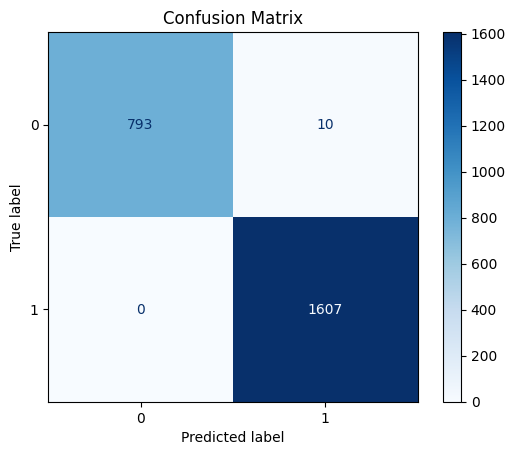

In [55]:
predict_with_ensemble(df_sample)

In [56]:
df_sample

,mH2,mA,mHpm,tan_beta,mH1,tan_alpha,v,lambda1,lambda2,lambda4,lambda5,lambda3,label
0,435.742590,89.618927,350.561463,13.458031,125,13.458031,246,568.525757,0.275519,-3.928798,-0.132718,1.182168,0
1,292.142661,203.635027,360.730942,1.812086,125,1.812086,246,4.889224,0.687695,-3.615348,-0.685227,3.148445,1
2,420.294741,92.232428,532.115997,0.749210,125,0.749210,246,1.896690,5.458522,-9.217200,-0.140571,6.696943,1
3,340.426458,576.756628,85.682460,54.392386,125,54.392386,246,5665.945689,0.258843,5.254234,-5.496864,-1.414208,0
4,314.344119,335.905116,626.780383,0.830821,125,0.830821,246,1.385278,2.623710,-11.118961,-1.864503,11.608832,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2405,230.756665,522.604232,459.336084,0.579050,125,0.579050,246,0.553229,2.882451,-2.459913,-4.513107,6.351306,1
2406,817.219131,752.712090,200.514723,63.785989,125,63.785989,246,44901.403926,0.260909,8.033630,-9.362408,-9.448903,0
2407,369.005661,306.043233,685.945476,46.396661,125,46.396661,246,4843.869687,0.259241,-14.002577,-1.547731,13.558434,0
2408,172.588164,488.983466,366.454120,0.798427,125,0.798427,246,0.571974,1.030310,-0.487019,-3.951101,4.204104,1


In [57]:
label = df_sample[df_sample['label']==1]
label

,mH2,mA,mHpm,tan_beta,mH1,tan_alpha,v,lambda1,lambda2,lambda4,lambda5,lambda3,label
1,292.142661,203.635027,360.730942,1.812086,125,1.812086,246,4.889224,0.687695,-3.615348,-0.685227,3.148445,1
2,420.294741,92.232428,532.115997,0.749210,125,0.749210,246,1.896690,5.458522,-9.217200,-0.140571,6.696943,1
4,314.344119,335.905116,626.780383,0.830821,125,0.830821,246,1.385278,2.623710,-11.118961,-1.864503,11.608832,1
5,583.648742,632.100187,375.670016,0.924924,125,0.924924,246,5.073740,6.838114,1.938243,-6.602397,-0.706671,1
6,405.061023,164.523562,443.452015,0.990098,125,0.990098,246,2.916024,3.023956,-6.051811,-0.447287,4.046037,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2402,305.579225,421.092685,370.103213,1.165597,125,1.165597,246,2.354597,1.393941,-1.596829,-2.930118,3.242103,1
2404,370.774094,360.756067,418.819062,1.308834,125,1.308834,246,4.149702,1.584306,-3.646538,-2.150587,3.783634,1
2405,230.756665,522.604232,459.336084,0.579050,125,0.579050,246,0.553229,2.882451,-2.459913,-4.513107,6.351306,1
2408,172.588164,488.983466,366.454120,0.798427,125,0.798427,246,0.571974,1.030310,-0.487019,-3.951101,4.204104,1


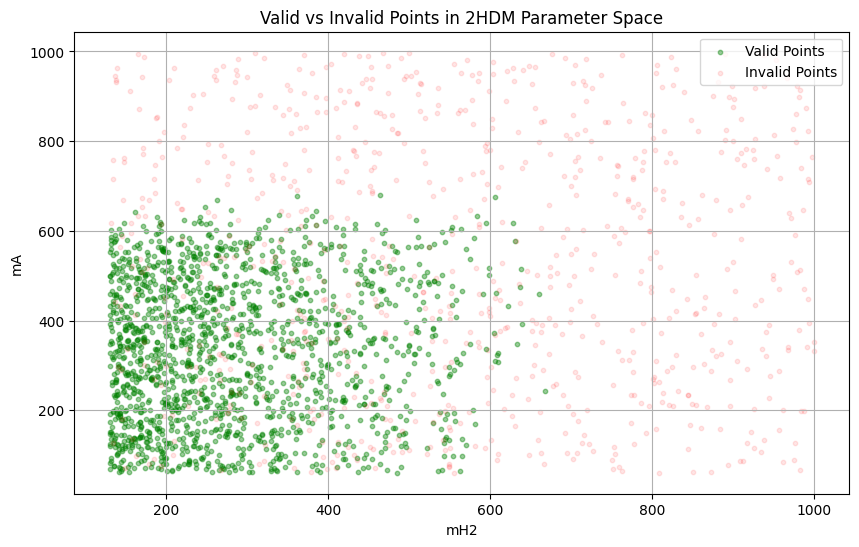

In [64]:
valid_points = df_sample[df_sample['label'] == 1]
invalid_points =df_sample[df_sample['label'] == 0]

plt.figure(figsize=(10, 6))
plt.scatter(valid_points['mH2'], valid_points['mA'], color='green', label='Valid Points', alpha=0.4, s=10)
plt.scatter(invalid_points['mH2'], invalid_points['mA'], color='red', label='Invalid Points', alpha=0.1, s=10)
plt.grid(True)
plt.xlabel('mH2')
plt.ylabel('mA')
plt.title('Valid vs Invalid Points in 2HDM Parameter Space')
plt.legend()
plt.show()


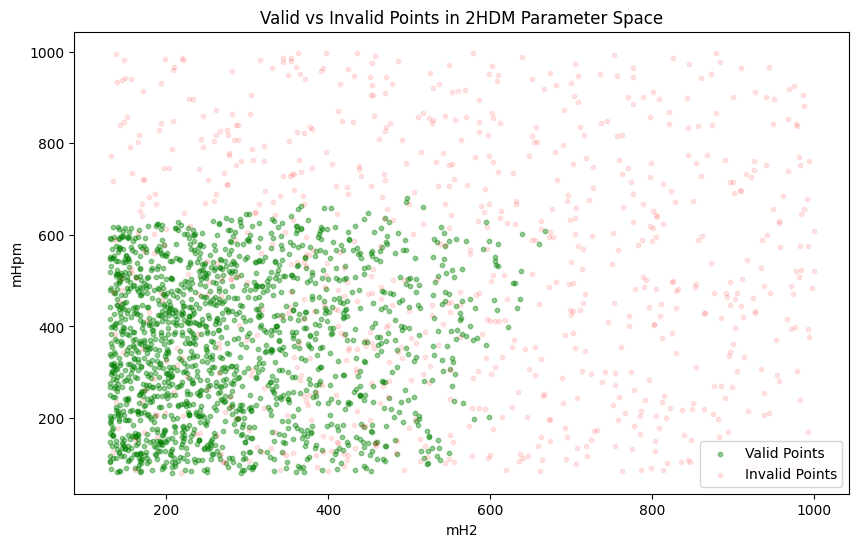

In [59]:
valid_points = df_sample[df_sample['label'] == 1]
invalid_points =df_sample[df_sample['label'] == 0]

plt.figure(figsize=(10, 6))
plt.scatter(valid_points['mH2'], valid_points['mHpm'], color='green', label='Valid Points', alpha=0.4, s=10)
plt.scatter(invalid_points['mH2'], invalid_points['mHpm'], color='red', label='Invalid Points', alpha=0.1, s=10)
plt.xlabel('mH2')
plt.ylabel('mHpm')
plt.title('Valid vs Invalid Points in 2HDM Parameter Space')
plt.legend()
plt.show()

In [60]:
# pip install ydata-profiling

In [61]:
# from pandas_profiling import ProfileReport
# ProfileReport(df_sample)

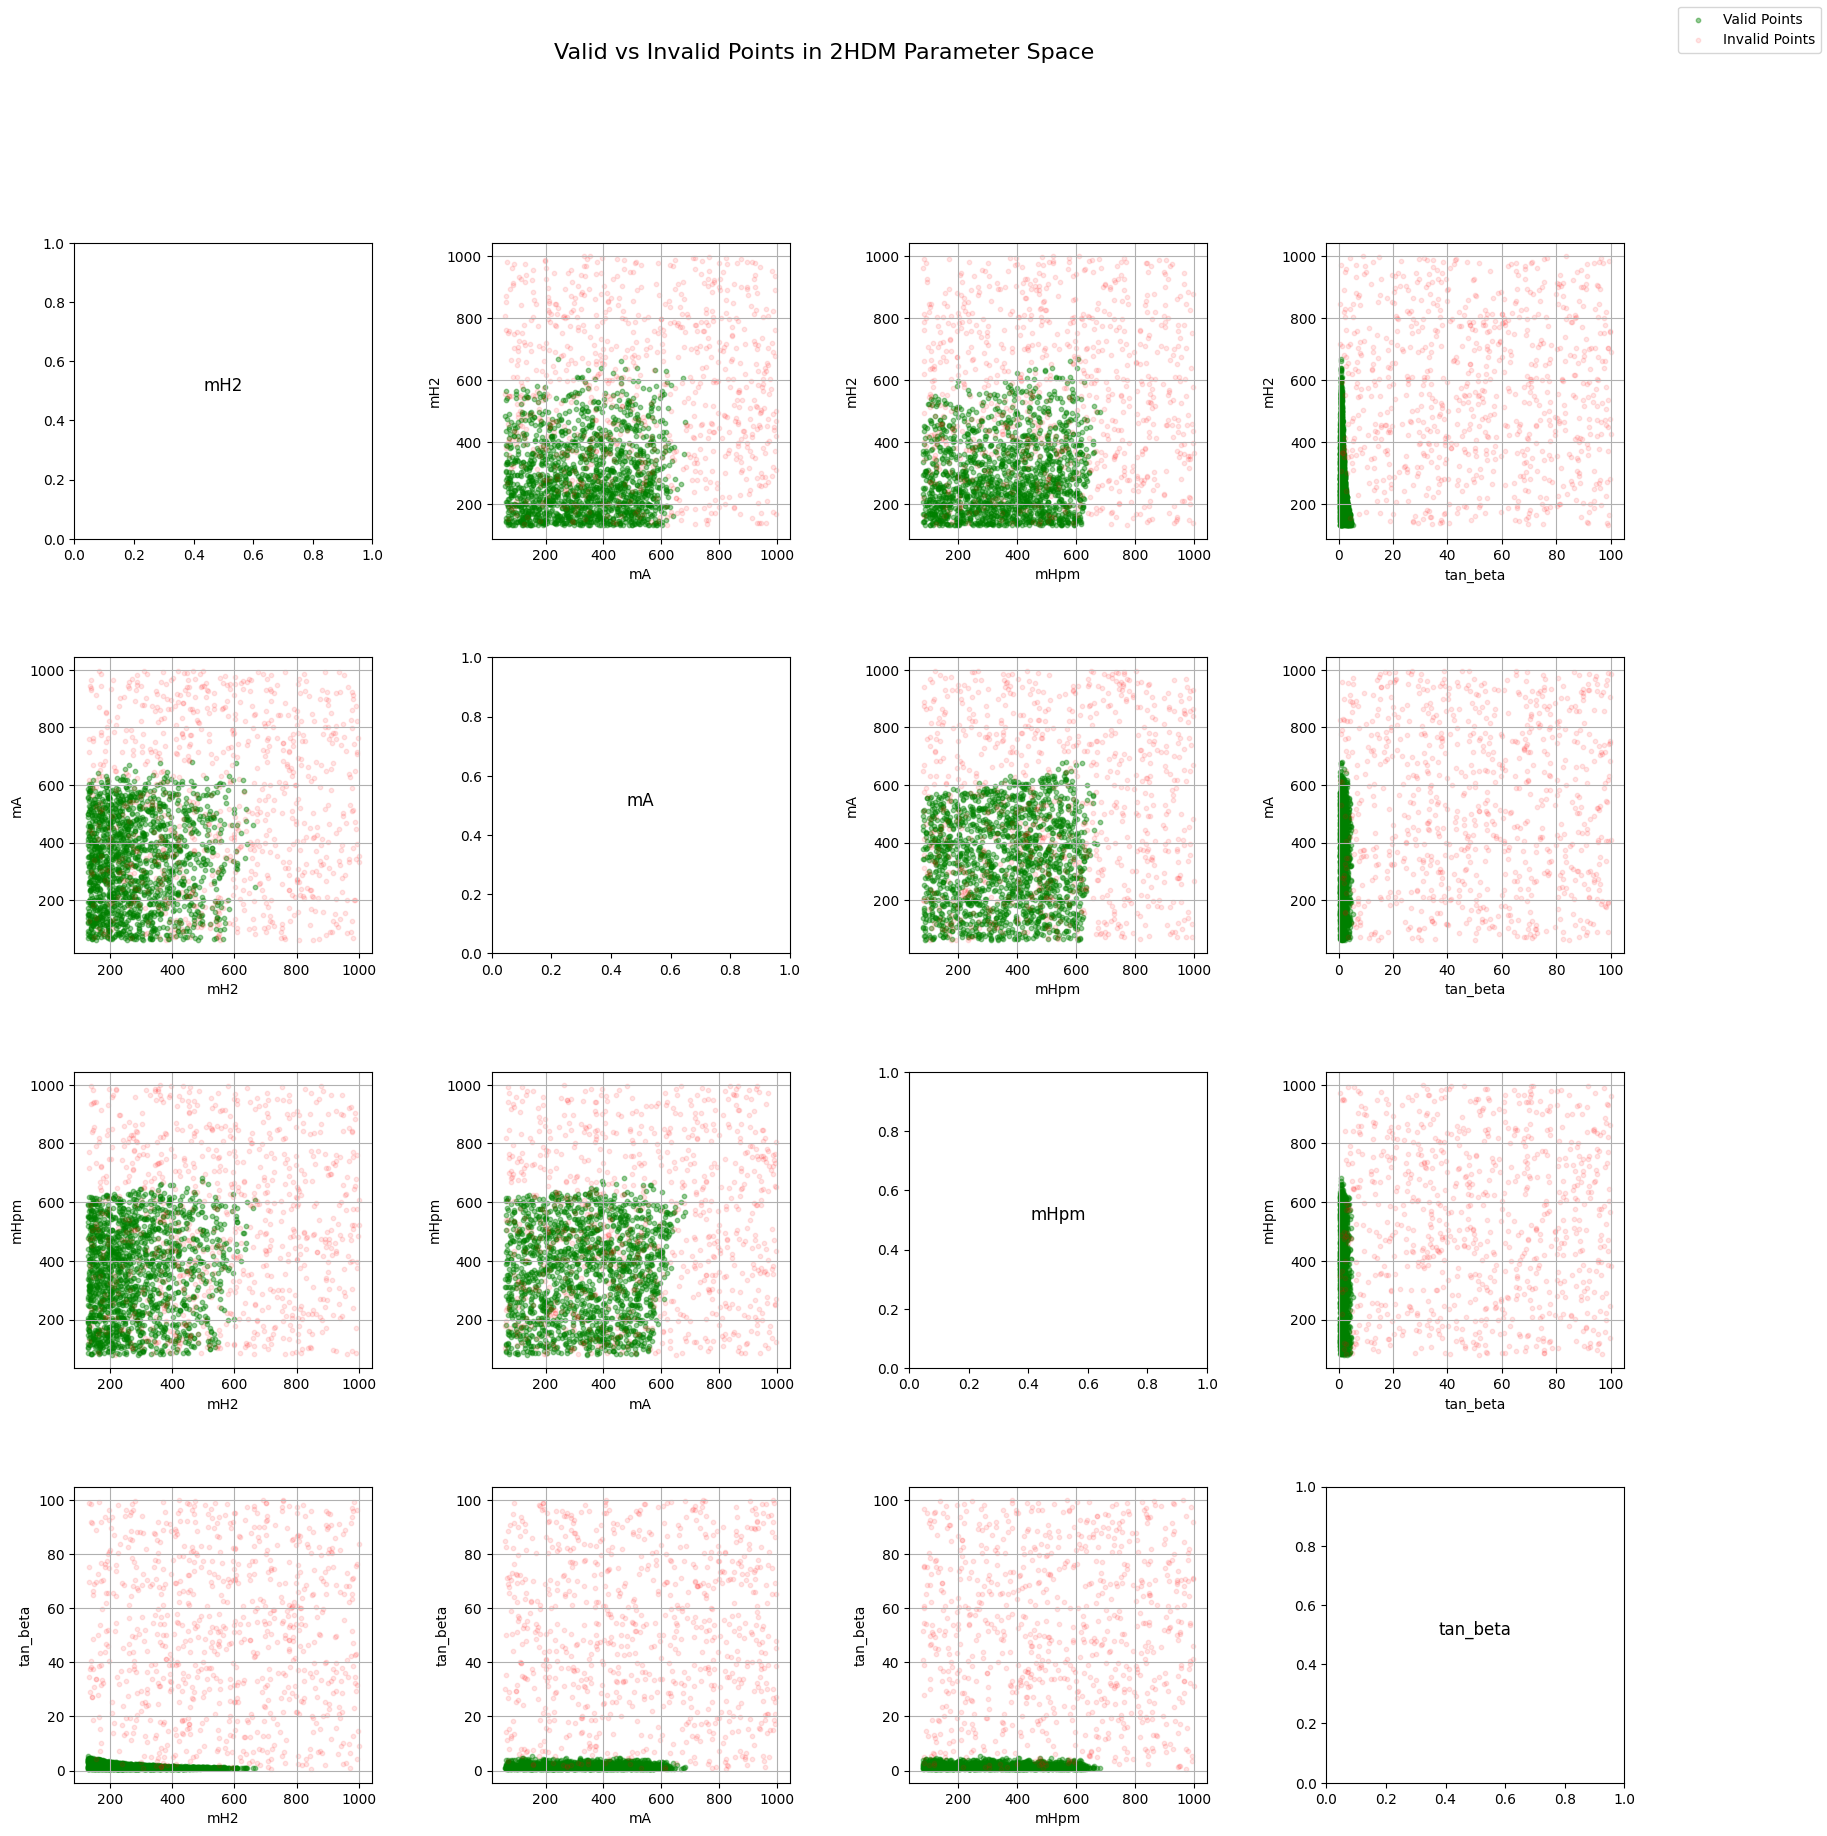

In [62]:
import matplotlib.pyplot as plt
import pandas as pd


valid_points = df_sample[df_sample['label'] == 1]
invalid_points = df_sample[df_sample['label'] == 0]

# List of features to plot
features = ['mH2', 'mA', 'mHpm', 'tan_beta']

# Create subplots
fig, axs = plt.subplots(len(features), len(features), figsize=(20, 20))
plt.subplots_adjust(hspace=0.4, wspace=0.4)

for i in range(len(features)):
    for j in range(len(features)):
        if i != j:
            # Scatter plot for valid points
            axs[i, j].scatter(valid_points[features[j]], valid_points[features[i]], color='green', label='Valid Points', alpha=0.4, s=10)
            # Scatter plot for invalid points
            axs[i, j].scatter(invalid_points[features[j]], invalid_points[features[i]], color='red', label='Invalid Points', alpha=0.1, s=10)
            axs[i, j].set_xlabel(features[j])
            axs[i, j].set_ylabel(features[i])
            axs[i, j].grid(True)  
        else:
            axs[i, j].text(0.5, 0.5, features[i], fontsize=12, ha='center')
            axs[i, j].grid(False)  

handles, labels = axs[0, 1].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right')

plt.suptitle('Valid vs Invalid Points in 2HDM Parameter Space', fontsize=16)
plt.show()
